# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from itertools import combinations
import lightgbm as lgb
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/claims_data.csv'
df = pd.read_csv(file_path)
df.head()

Mounted at /content/drive


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85




# Building the DataFrame

In [ ]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB
None
                  id          cont1          cont2          cont3  \
count  188318.000000  188318.000000  188318.000000  188318.000000   
mean   294135.982561       0.493861       0.507188       0.498918   
std    169336.084867       0.187640       0.207202       0.202105   
min         1.000000       0.000016       0.001149       0.002634   
25%    147748.250000       0.346090       0.358319       0.336963   
50%    294539.500000       0.475784       0.555782       0.527991   
75%    440680.500000       0.623912       0.681761       0.634224   
max    587633.000000       0.984975       0.862654       0.944251   

               cont4          cont5          cont6          cont7  \
count  188318.000000  188318.000000  188318.000000  188318.000000   
mean        0.491812       0.487428       0.490945       

In [ ]:
# Count of continuous (float64) and categorical (int64 or object) variables
continuous_vars = df.select_dtypes(include=['float64']).shape[1]
categorical_vars = df.select_dtypes(exclude=['float64']).shape[1]

print(f"Number of continuous variables: {continuous_vars}")
print(f"Number of categorical variables: {categorical_vars}")


Number of continuous variables: 15
Number of categorical variables: 117


# Exploratory Data Analysis

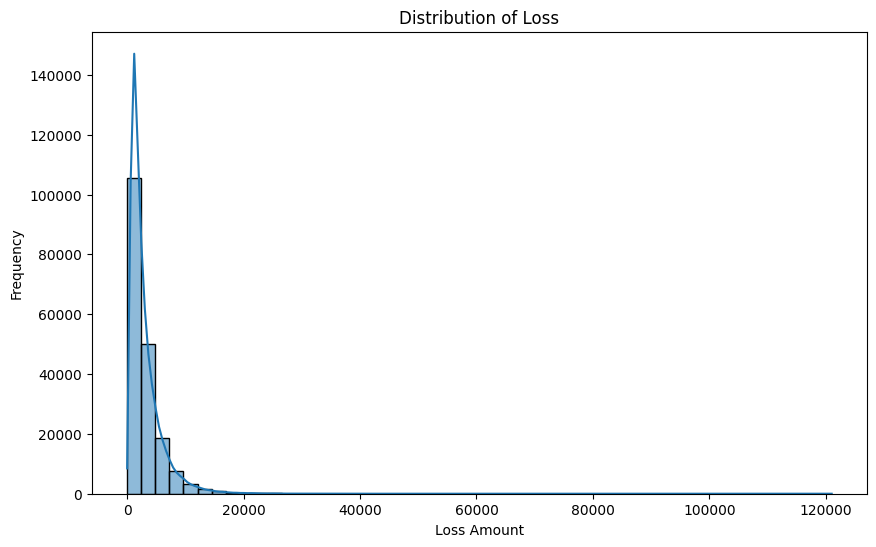

In [ ]:
# Plot distribution of the 'loss' variable
plt.figure(figsize=(10, 6))
sns.histplot(df['loss'], kde=True, bins=50)
plt.title('Distribution of Loss')
plt.xlabel('Loss Amount')
plt.ylabel('Frequency')
plt.show()

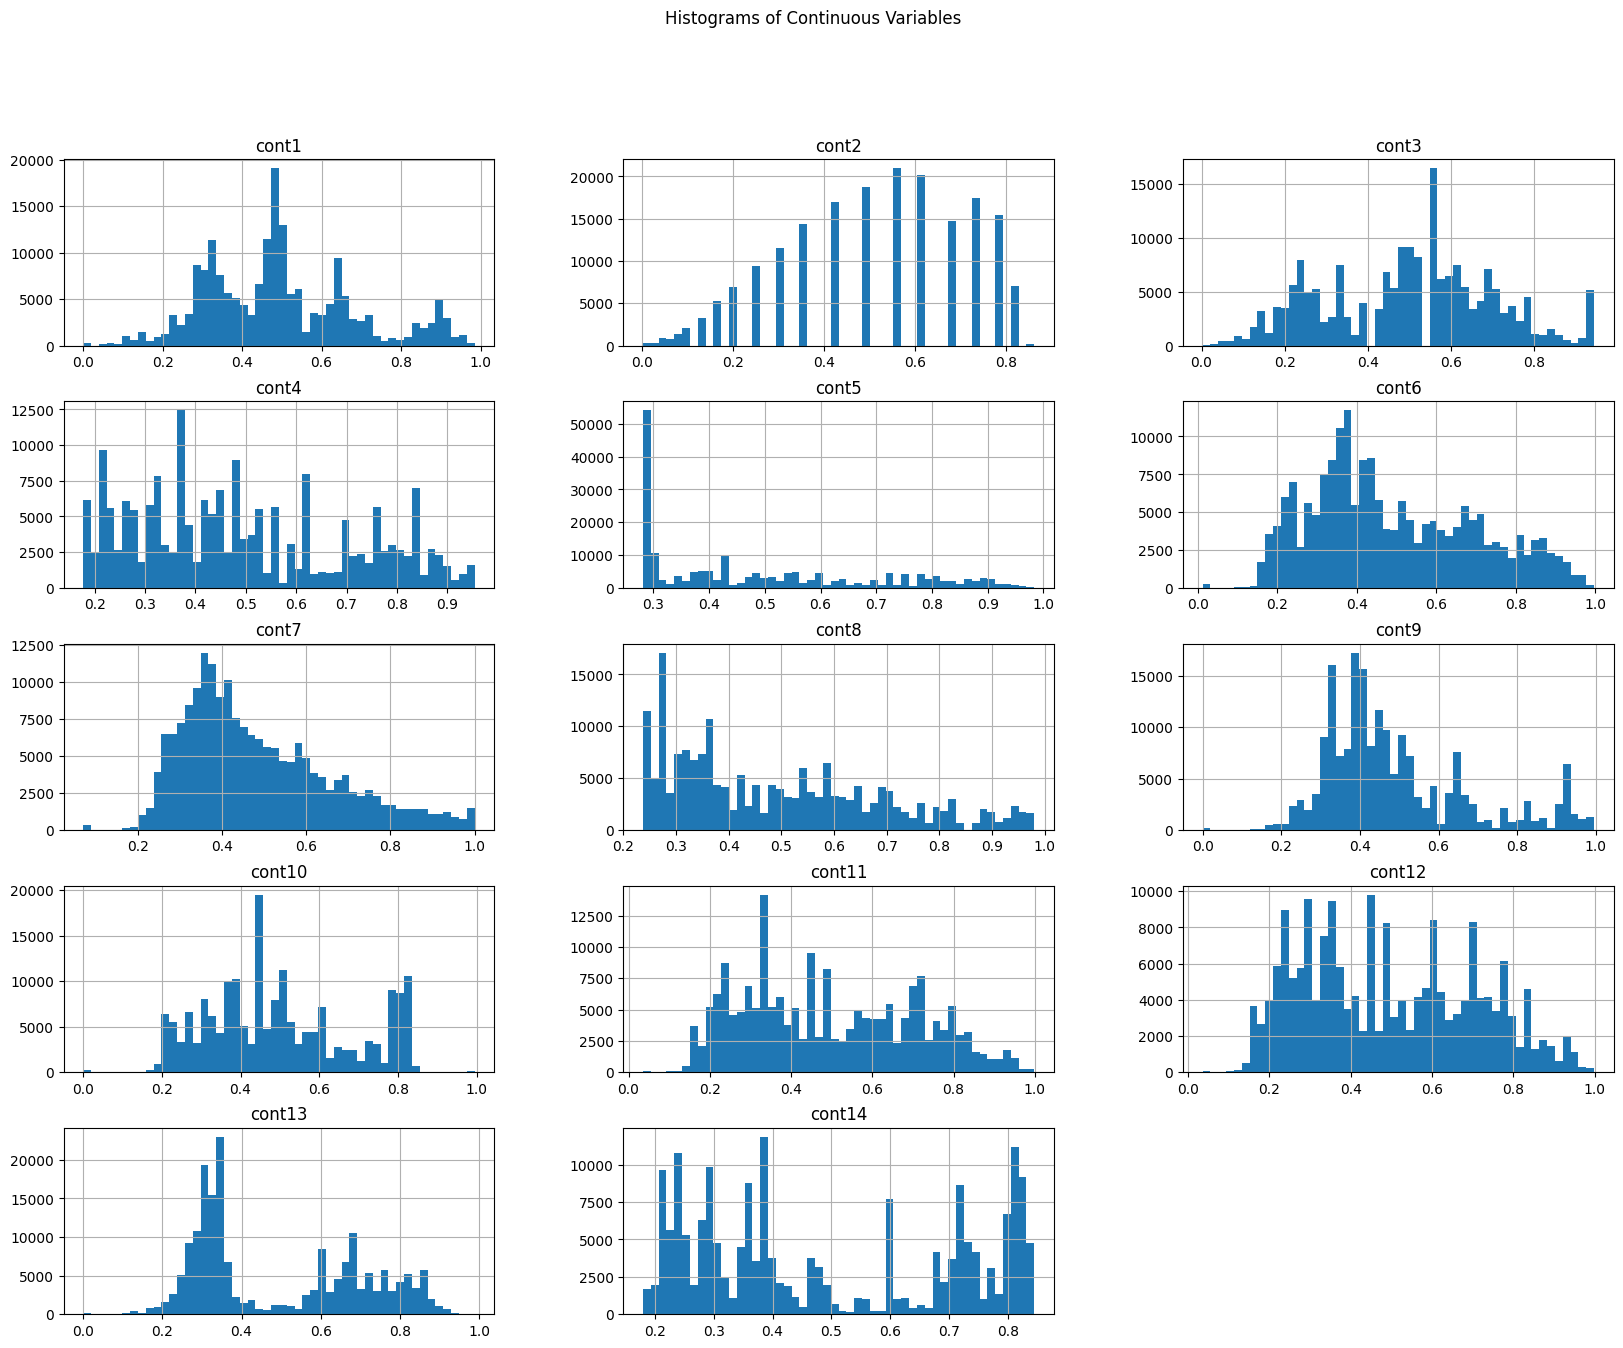

In [ ]:
# Plot histograms for continuous variables
df[df.columns[df.columns.str.startswith('cont')]].hist(figsize=(20, 15), bins=50, layout=(5, 3))
plt.suptitle('Histograms of Continuous Variables')
plt.show()

## ***Correlation Matrix for Continuous Features***

In [ ]:
# Compute the correlation matrix
corr = df[df.columns[df.columns.str.startswith('cont')]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the heatmap with the mask
plt.figure(figsize=(12, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Continuous Variables')
plt.show()

## ***Correlation Matrix for Categorical Features***

In [ ]:
# Split columns into five groups ( we have 116 cat features)
cat_columns = [col for col in df.columns if col.startswith('cat')]

group_1 = cat_columns[:25]
group_2 = cat_columns[25:50]
group_3 = cat_columns[50:75]
group_4 = cat_columns[75:100]
group_5 = cat_columns[100:]

# Store groups in a list
groups = [group_1, group_2, group_3, group_4, group_5]

# Store the pairs with a corr of 0.88 or higher
high_corr_pairs = {}

# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Loop over pairs of groups
for i in range(len(groups)):
    for j in range(i, len(groups)):
        group1 = groups[i]
        group2 = groups[j]

        # Initialize a DataFrame to store Cramér's V values
        cramers_v_matrix = pd.DataFrame(index=group1, columns=group2)

        # Calculate Cramér's V for each pair of categorical columns between the two groups
        for col1 in group1:
            for col2 in group2:
                cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
                if cramers_v(df[col1], df[col2]) > 0.88:
                    high_corr_pairs[(col1, col2)] = cramers_v(df[col1], df[col2])

        # Convert the matrix to numeric
        cramers_v_matrix = cramers_v_matrix.astype(float)

        annotations = cramers_v_matrix.applymap(lambda x: f'{x:.2f}'[1:])

        # Plot the heatmap
        plt.figure(figsize=(15, 15))
        mask = np.triu(np.ones_like(cramers_v_matrix, dtype=bool))  # Mask to display only the lower triangle
        sns.heatmap(cramers_v_matrix, mask=mask, annot=annotations, cmap='coolwarm', cbar=True, fmt='', annot_kws={"size": 10, "weight": "bold", "va": 'center'})
        plt.title(f"Heatmap of Cramér's V: Group {i+1} vs Group {j+1}")
        plt.show()

In [ ]:
# Get all categorical columns
cat_columns = df.select_dtypes(include=['object']).columns.tolist()

# Initialize an empty DataFrame to store p-values
p_values_matrix = pd.DataFrame(np.ones((len(cat_columns), len(cat_columns))),
                               index=cat_columns, columns=cat_columns)

# Iterate over pairs of categorical variables
for cat1, cat2 in combinations(cat_columns, 2):
    # Create a contingency table for the two variables
    contingency_table = pd.crosstab(df[cat1], df[cat2])

    # Perform the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Store p-value in the matrix
    p_values_matrix.loc[cat1, cat2] = p
    p_values_matrix.loc[cat2, cat1] = p  # Ensure symmetry

# Create a mask to show only lower triangle
mask = np.triu(np.ones_like(p_values_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(p_values_matrix, annot=False, cmap='coolwarm', mask=mask,
            cbar_kws={'label': 'p-value'}, vmin=0, vmax=1)
plt.title('Chi-Square Test p-values Between Categorical Variables')
plt.show()

In [ ]:
# Calculate z-scores for all continuous variables
z_scores = stats.zscore(df[df.columns[df.columns.str.startswith('cont')]])

# Convert the z-scores back into a DataFrame for easier handling
z_scores_df = pd.DataFrame(z_scores, columns=df.columns[df.columns.str.startswith('cont')])

# Identify outliers based on z-score
outliers = (z_scores_df < -3) | (z_scores_df > 3)
outlier_counts = outliers.sum()
print(outlier_counts)

In [ ]:
#Z-Scores Box Plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=z_scores_df)
plt.title('Box Plot of Z-Scores for Continuous Variables')
plt.ylabel('Z-Score')
plt.xlabel('Continuous Variables')
plt.xticks(rotation=45)
plt.show()

In [ ]:
continuous_variables = df.columns[df.columns.str.startswith('cont')]

for variable in continuous_variables:
    plt.figure(figsize=(10, 6))

    # Create bins for the continuous variable
    bins = pd.cut(df[variable], bins=10)  # You can adjust the number of bins as needed

    # Group by bins and calculate the mean loss
    grouped_data = df.groupby(bins)['loss'].mean().reset_index()

    # Convert the bin intervals to the midpoints for plotting
    grouped_data['bin_midpoint'] = grouped_data[variable].apply(lambda x: x.mid)

    # Plot the mean loss for each bin midpoint
    sns.scatterplot(x=grouped_data['bin_midpoint'], y=grouped_data['loss'])

    plt.title(f'Binned Scatter Plot of {variable} vs Mean Loss')
    plt.xlabel(f'{variable} (binned midpoints)')
    plt.ylabel('Mean Loss')
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
categorical_variables = df.select_dtypes(include=['object']).columns

subset_of_variables = categorical_variables[:10]

for col in subset_of_variables:
    plt.figure(figsize=(10, 6))

    # Group by categorical variable and calculate the mean loss
    grouped_data = df.groupby(col)['loss'].mean().reset_index()

    # Sort the values to make the plot more readable
    grouped_data = grouped_data.sort_values('loss')

    # Plot the mean loss for each category
    sns.barplot(x=grouped_data[col], y=grouped_data['loss'])

    plt.title(f'Bar Plot of {col} vs Mean Loss')
    plt.xlabel(col)
    plt.ylabel('Mean Loss')
    plt.xticks(rotation=45)
    plt.show()

# **2. Data Preparation**

## ***2.1 Feature Aggregation (alternative step to avoid multicollinearity if our chosen model is susceptive to it)***

  ## ***a. Continuous Features***

In [ ]:
# Compute the correlation matrix
corr = df[df.columns[df.columns.str.startswith('cont')]].corr()

# Find pairs of features with high correlation
high_corr_pairs = corr.abs().unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1]  # Exclude self-correlation

print("\nHigh Correlation Pairs:")
print(high_corr_pairs)


High Correlation Pairs:
cont11  cont12    0.994384
cont12  cont11    0.994384
cont1   cont9     0.929912
cont9   cont1     0.929912
cont6   cont10    0.883351
                    ...   
        cont2     0.015864
cont5   cont8     0.009015
cont8   cont5     0.009015
cont12  cont3     0.006111
cont3   cont12    0.006111
Length: 182, dtype: float64


In [ ]:
# Combine features into a new features when they have a correlation of 88 or greater
df['average_cont9_cont1'] = (df['cont1'] + df['cont9']) / 2
df['average_cont10_cont6'] = (df['cont6'] + df['cont10']) / 2
df['average_cont12_cont11'] = (df['cont11'] + df['cont12']) / 2

# Drop the original features
df = df.drop(columns=['cont1', 'cont9', 'cont6', 'cont10', 'cont11', 'cont12'])

print("\nDataFrame after removing original features:")
print(df)


DataFrame after removing original features:
            id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont4  \
0            1    A    B    A    B    A    A    A    A    B  ...  0.789639   
1            2    A    B    A    A    A    A    A    A    B  ...  0.614134   
2            5    A    B    A    A    B    A    A    A    B  ...  0.236924   
3           10    B    B    A    B    A    A    A    A    B  ...  0.373816   
4           11    A    B    A    B    A    A    A    A    B  ...  0.473202   
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
188313  587620    A    B    A    A    A    A    A    A    B  ...  0.473202   
188314  587624    A    A    A    A    A    B    A    A    A  ...  0.802892   
188315  587630    A    B    A    A    A    A    A    B    B  ...  0.189137   
188316  587632    A    B    A    A    A    A    A    A    B  ...  0.383428   
188317  587633    B    A    A    B    A    A    A    A    A  ...  0.821574   

           cont5  

## ***b. Categorical Features***

In [ ]:
print(high_corr_pairs)

cont11  cont12    0.994384
cont12  cont11    0.994384
cont1   cont9     0.929912
cont9   cont1     0.929912
cont6   cont10    0.883351
                    ...   
        cont2     0.015864
cont5   cont8     0.009015
cont8   cont5     0.009015
cont12  cont3     0.006111
cont3   cont12    0.006111
Length: 182, dtype: float64


In [ ]:
# Create a set to store unique pairs
unique_pairs = set()

# Filter pairs
filtered_pairs = {
    pair: corr for pair, corr in high_corr_pairs.items()
    if pair[0] != pair[1] and corr >= 0.99
}

# Add pairs to the set in a sorted order
for pair in filtered_pairs:
    sorted_pair = tuple(sorted(pair))
    unique_pairs.add(sorted_pair)

print("Unique pairs:", unique_pairs)

Unique pairs: {('cont11', 'cont12')}


In [ ]:
# Drop features with a 1.0 correlation
for pair in unique_pairs:
    feature1, feature2 = pair
    new_feature_name = f'{feature1}_{feature2}'

    # Rename feature1 to a new combined name
    if feature1 in df.columns:
        df = df.rename(columns={feature1: new_feature_name})

    # Drop feature2 only if it exists in the columns
    if feature2 in df.columns:
        df = df.drop(columns=[feature2])

print(df)

            id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont4  \
0            1    A    B    A    B    A    A    A    A    B  ...  0.789639   
1            2    A    B    A    A    A    A    A    A    B  ...  0.614134   
2            5    A    B    A    A    B    A    A    A    B  ...  0.236924   
3           10    B    B    A    B    A    A    A    A    B  ...  0.373816   
4           11    A    B    A    B    A    A    A    A    B  ...  0.473202   
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
188313  587620    A    B    A    A    A    A    A    A    B  ...  0.473202   
188314  587624    A    A    A    A    A    B    A    A    A  ...  0.802892   
188315  587630    A    B    A    A    A    A    A    B    B  ...  0.189137   
188316  587632    A    B    A    A    A    A    A    A    B  ...  0.383428   
188317  587633    B    A    A    B    A    A    A    A    A  ...  0.821574   

           cont5     cont7    cont8    cont13    cont14     los

## ***2.2 One Hot Encoding the Categorical Values.***


In [ ]:
# Select the categorical columns
cat_columns = df.select_dtypes(include=['object']).columns.tolist()

# Check if 'cat116' is in the categorical columns
if 'cat116' in cat_columns:
    # Calculate the mean of the target ('loss') for each category in 'cat116'
    target_means = df.groupby('cat116')['loss'].mean()

    # Map the target means to each value in 'cat116'
    df['cat116_encoded'] = df['cat116'].map(target_means)

    # Remove 'cat116' from the list of categorical columns after encoding
    cat_columns.remove('cat116')

# Initialize OneHotEncoder for the remaining categorical columns
encoder = OneHotEncoder(sparse_output=False)

# One-hot encode the remaining categorical columns
one_hot_encoded = encoder.fit_transform(df[cat_columns])

# Create a DataFrame for the one-hot encoded variables
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(cat_columns))

# Concatenate the original DataFrame with the new one-hot encoded columns
df = pd.concat([df.drop(cat_columns + ['cat116'], axis=1), one_hot_df], axis=1)


# Display results
print(f"Encoded data:\n{df.head()}")
print("\nColumns after encoding:\n", df.columns.tolist())

Encoded data:
   id     cont2     cont3     cont4     cont5     cont7    cont8    cont13  \
0   1  0.245921  0.187583  0.789639  0.310061  0.335060  0.30260  0.822493   
1   2  0.737068  0.592681  0.614134  0.885834  0.436585  0.60087  0.611431   
2   5  0.358319  0.484196  0.236924  0.397069  0.315545  0.27320  0.195709   
3  10  0.555782  0.527991  0.373816  0.422268  0.391128  0.31796  0.605077   
4  11  0.159990  0.527991  0.473202  0.704268  0.247408  0.24564  0.246011   

     cont14     loss  ...  cat115_N  cat115_O  cat115_P  cat115_Q  cat115_R  \
0  0.714843  2213.18  ...       0.0       1.0       0.0       0.0       0.0   
1  0.304496  1283.60  ...       0.0       1.0       0.0       0.0       0.0   
2  0.774425  3005.09  ...       0.0       0.0       0.0       0.0       0.0   
3  0.602642   939.85  ...       0.0       1.0       0.0       0.0       0.0   
4  0.432606  2763.85  ...       0.0       0.0       0.0       0.0       0.0   

   cat115_S  cat115_T  cat115_U  cat115_W 

# **3. Models**

In [ ]:
X = df.drop(columns='loss')
y = df['loss']

# Split the dataset into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

[0]	validation_0-rmse:2761.83239	validation_1-rmse:2867.91979
[1]	validation_0-rmse:2650.55720	validation_1-rmse:2764.74774
[2]	validation_0-rmse:2554.88198	validation_1-rmse:2678.24587
[3]	validation_0-rmse:2470.87763	validation_1-rmse:2602.82615
[4]	validation_0-rmse:2399.02408	validation_1-rmse:2540.43181
[5]	validation_0-rmse:2335.59582	validation_1-rmse:2487.06574
[6]	validation_0-rmse:2282.10771	validation_1-rmse:2441.89091
[7]	validation_0-rmse:2233.98584	validation_1-rmse:2401.52527
[8]	validation_0-rmse:2192.34184	validation_1-rmse:2367.37291
[9]	validation_0-rmse:2153.83439	validation_1-rmse:2337.96813
[10]	validation_0-rmse:2119.29286	validation_1-rmse:2311.21299
[11]	validation_0-rmse:2087.72476	validation_1-rmse:2288.29804
[12]	validation_0-rmse:2060.98814	validation_1-rmse:2268.07759
[13]	validation_0-rmse:2035.87573	validation_1-rmse:2251.40566
[14]	validation_0-rmse:2014.87792	validation_1-rmse:2237.27117
[15]	validation_0-rmse:1994.16080	validation_1-rmse:2222.43284
[1

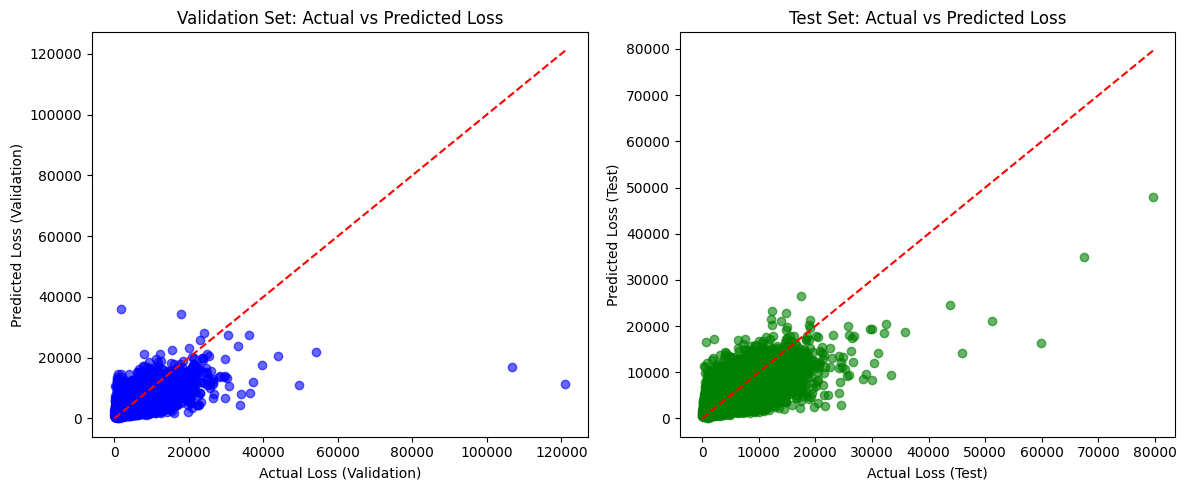

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=200, learning_rate = 0.1, min_child_weight = 1, max_depth=7,
                         early_stopping_rounds=20, gamma = 0,
                         reg_lambda = 1, alpha = 1)


# Train model with early stopping
model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)])

# Evaluate on validation set
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
print(f'Validation Mean Squared Error: {val_mse}')

# Evaluate on test set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test Mean Squared Error: {test_mse}')


# Plot Predicted vs Actual for Validation Set
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_val_pred, color='blue', alpha=0.6)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.xlabel("Actual Loss (Validation)")
plt.ylabel("Predicted Loss (Validation)")
plt.title("Validation Set: Actual vs Predicted Loss")

# Plot Predicted vs Actual for Test Set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color='green', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Loss (Test)")
plt.ylabel("Predicted Loss (Test)")
plt.title("Test Set: Actual vs Predicted Loss")

# Show plots
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import r2_score

rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)
print(test_r2)
print(rmse)

0.5820185949621326
1846.7704181673566


In [ ]:
# Compute the mean of the training target values (y_train)
mean_train = np.mean(y_train)

# Predict the mean for all instances in the validation and test sets
y_val_pred_mean = np.full_like(y_val, mean_train)
y_test_pred_mean = np.full_like(y_test, mean_train)

# Evaluate performance on the validation set
val_mse = mean_squared_error(y_val, y_val_pred_mean)
val_rmse_b = np.sqrt(val_mse)
print(f'Validation Root Mean Squared Error (mean baseline): {val_rmse_b}')


# Evaluate performance on the test set
test_mse = mean_squared_error(y_test, y_test_pred_mean)
test_rmse_b = np.sqrt(test_mse)
print(f'Test Root Mean Squared Error (mean baseline): {rmse}')

Validation Root Mean Squared Error (mean baseline): 2988.003784239835
Test Root Mean Squared Error (mean baseline): 1846.7704181673566


In [ ]:
# Calculate the percentage reduction in RMSE for the validation set
percentage_reduction = ((test_rmse_b - rmse) / test_rmse_b) * 100

# Print the result
print(f"Percentage Reduction in RMSE: {percentage_reduction:.2f}%")

Percentage Reduction in RMSE: 35.35%
